# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

33412


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Refgen for gene dist matrix

Example of [refgen](../0_locus_annotation/resources/refgen_df_for_jie.csv)

In [9]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [10]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [11]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load AB comartment and density 

## chrZXY

Data below can be generated from notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [12]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

class_2_chr2Zxys_filename = os.path.join(postanalysis_folder, 'class_2_chr2Zxys.pkl')
class_2_chr2ZxysList = pickle.load(open(class_2_chr2Zxys_filename, 'rb'))

In [13]:
class_2_chr2ZxysList.keys()

dict_keys(['Gluta', 'GABA', 'Astro', 'Endo', 'Micro', 'Oligo'])

## AB compartment

Data be can generated from notebook as:

[2_ab_compartment_assignment_threshold_zero](2_ab_compartment_assignment_threshold_zero.ipynb)


Example of data is in the repository as [AB_assignment_shared_ABth_zero](../4_compartment_analysis/resources/AB_assignment_shared_ABth_zero.csv)

In [14]:
AB_summary_fname = os.path.join(output_analysis_folder,'AB_assignment_shared_ABth_zero.csv')
AB_summary_df = pd.read_csv(AB_summary_fname, index_col=0)

AB_summary_df

,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,B,B,B,B,B,B
chr1_6245958_6258969,A,B,B,B,B,B
chr1_8740008_8759916,B,B,B,B,B,B
chr1_9627926_9637875,A,B,B,B,A,B
chr1_9799472_9811359,A,B,B,B,A,A
...,...,...,...,...,...,...
chrX_163750534_163758706,A,A,A,A,A,A
chrX_166247682_166259932,A,A,A,A,A,A
chrX_167157164_167167452,A,A,A,A,A,A


## trans AB ratio single cell

Data below can be generated from notebook:

[5_compute_ab_trans_density_singlecelll_majortype](5_compute_ab_trans_density_singlecelll_majortype.ipynb)

In [15]:
import pickle
gaussian_radius= 0.5
transABratio_ensemble_filename = os.path.join(output_analysis_folder, f'trans_AB_ratio_notNorm_r{gaussian_radius}_byclass_th_zero.pkl')
if os.path.exists(transABratio_ensemble_filename):
    print(transABratio_ensemble_filename)
    trans_AB_ratio_by_group = pickle.load(open(transABratio_ensemble_filename, 'rb'))

L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis\trans_AB_ratio_notNorm_r0.5_byclass_th_zero.pkl


In [16]:
trans_AB_ratio_by_group.keys()

dict_keys(['Gluta', 'GABA', 'Astro', 'Endo', 'Micro', 'Oligo'])

# 4. Plot singel cell example

## functions for summariz and plot

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [18]:
from tqdm import tqdm
from ImageAnalysis3.compartment_tools.density import BatchCompartmentDensities
reload(ia.compartment_tools.density)
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict
reload(ia.figure_tools.plot_decode)

from ImageAnalysis3.structure_tools import distance
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=False)

In [19]:
def summarize_chr2Zxys(chr_2_zxys_list, codebook_df, keep_valid=False):
    # generate an order and sort by chr
    _chr_2_indices, _ = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=False) 
    _merged_zxys = []
    _merged_region_ids = []
    
    for _chr_name, _chr_inds in chr_2_indices.items():
        if _chr_name in chr_2_zxys_list:
            _zxys_list = chr_2_zxys_list[_chr_name]
            for _zxys in _zxys_list:
                if keep_valid:
                    if len(np.shape(_zxys)) == 2:
                        _valid_flags = np.isfinite(_zxys).all(1)
                    else:
                        _valid_flags = np.isfinite(_zxys)
                    _merged_zxys.append(_zxys[_valid_flags])
                    _merged_region_ids.append(_chr_inds[_valid_flags])
                else:
                    _merged_zxys.append(_zxys)
                    _merged_region_ids.append(_chr_inds)
    return np.concatenate(_merged_zxys), np.concatenate(_merged_region_ids)

In [20]:
def summarize_chr2Zxys_to_AB_binary(chr_2_zxys_list, codebook_df, AB_summary_arr, keep_valid=False):
    # generate an order and sort by chr
    _chr_2_indices, _ = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=False) 
    _merged_zxys_ABdict = {'A':[],'B':[]}
    _merged_region_ids_ABdict = {'A':[],'B':[]}
    
    for _chr_name, _chr_inds in chr_2_indices.items():
        if _chr_name in chr_2_zxys_list:
            _zxys_list = chr_2_zxys_list[_chr_name]
            # AB annotation for chr homologs
            sel_AB_summary_arr = AB_summary_arr[_chr_2_indices[_chr_name]]
            _zxys_list_A = _zxys_list[:,sel_AB_summary_arr=='A']
            _zxys_list_B = _zxys_list[:,sel_AB_summary_arr=='B']
            
            for _zxys_list_comp, _comp_type in zip([_zxys_list_A, _zxys_list_B],['A','B']):
                for _zxys in _zxys_list_comp:
                    if keep_valid:
                        if len(np.shape(_zxys)) == 2:
                            _valid_flags = np.isfinite(_zxys).all(1)
                        else:
                            _valid_flags = np.isfinite(_zxys)
                        _merged_zxys_ABdict[_comp_type].append(_zxys[_valid_flags])
                        _merged_region_ids_ABdict[_comp_type].append(_chr_inds[_valid_flags])
                    else:
                        _merged_zxys_ABdict[_comp_type].append(_zxys)
                        _merged_region_ids_ABdict[_comp_type].append(_chr_inds)
    
    output_merged_zxys_dict = {}
    output_merged_region_ids_dict = {}
    for _comp_type in ['A','B']:
        output_merged_zxys_dict[_comp_type] = np.concatenate(_merged_zxys_ABdict[_comp_type])
        output_merged_region_ids_dict[_comp_type] = np.concatenate(_merged_region_ids_ABdict[_comp_type])
        

    return output_merged_zxys_dict, output_merged_region_ids_dict


## select cells

In [21]:
sel_subclass = 'Gluta'
sel_cell_indices = []
for _cell_index, _chr2Zxys in enumerate(class_2_chr2ZxysList[sel_subclass]):
    if len(_chr2Zxys) >= 15:
        num_pts = 0
        for _chr, _chr_pts in _chr2Zxys.items():
            num_pts += np.sum(~np.isnan(_chr_pts))/3
        if num_pts >= 2200 and num_pts <= 4000:
            sel_cell_indices.append(_cell_index)
            
print(len(class_2_chr2ZxysList[sel_subclass]))
print(len(sel_cell_indices))

22173
177


## transA/B ratio

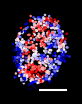

In [22]:
%matplotlib inline


refBar_len = 5 #(um)

sel_subclasses=sel_subclass
_sel_cell_ind = sel_cell_indices[7]

_chr2Zxys = class_2_chr2ZxysList[sel_subclasses][_sel_cell_ind]
_centered_chr2Zxys = ia.figure_tools.plot_decode.Centering_Chr2ZxysListDict(_chr2Zxys)
#_chr2cisABratios = subclass_2_cisABRatioDicts[sel_subclasses][_sel_cell_ind]
_chr2transABratios = trans_AB_ratio_by_group[sel_subclasses][_sel_cell_ind]
_cell_zxys, _cell_rids = summarize_chr2Zxys(_centered_chr2Zxys, codebook_df, keep_valid=True)
#_cell_cisABratios, _ = summarize_chr2Zxys(_chr2cisABratios, codebook, keep_valid=True)
_cell_transABratios, _ = summarize_chr2Zxys(_chr2transABratios, codebook_df, keep_valid=True)


_slice_flags = (_cell_zxys[:,0] >= -1) & (_cell_zxys[:,0] < 1) 

# plot
vmin, vmax=-3,4

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5))
_pf = ax.scatter(_cell_zxys[_slice_flags,1], _cell_zxys[_slice_flags,2], alpha=0.9,
                 c=_cell_transABratios[_slice_flags], s=1, cmap='seismic', vmin=vmin, vmax=vmax)
ax.set_aspect('equal')

#plt.colorbar(_pf, ax=ax)

# start coordinate for colorbar
_bar_starts = np.array([0,-7.5
                        ]) 
# therefore, end of colorbar
_bar_ends = np.array([0 + (refBar_len), -7.5
                        ]) 
#print(_bar_starts, _bar_ends)
_ref_line = ax.plot([_bar_starts[0], _bar_ends[0]],
                      [_bar_starts[1], _bar_ends[1]], 
                      color='white', 
                      linewidth=1.5)

plt.axis('off')
fig.savefig(os.path.join(output_figure_folder, f"{sel_subclass}_trans_ratio_example.pdf"),
                transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=300)

## A/B compartment

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_33412\1521885510.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  _pf = ax.scatter(_cell_zxys['A'][_slice_flags,1], _cell_zxys['A'][_slice_flags,2], alpha=0.9,
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_33412\1521885510.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  _pf = ax.scatter(_cell_zxys['B'][_slice_flags,1], _cell_zxys['B'][_slice_flags,2], alpha=0.9,


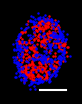

In [23]:
AB_summary_arr = np.array(AB_summary_df[sel_subclass].tolist())
_cell_zxys, _cell_rids = summarize_chr2Zxys_to_AB_binary(_centered_chr2Zxys, codebook_df, AB_summary_arr, keep_valid=False)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5))

_slice_flags = (_cell_zxys['A'][:,0] >= -1) & (_cell_zxys['A'][:,0] < 1)
_pf = ax.scatter(_cell_zxys['A'][_slice_flags,1], _cell_zxys['A'][_slice_flags,2], alpha=0.9, 
                 c='red', s=1,  vmin=-3, vmax=4)

_slice_flags = (_cell_zxys['B'][:,0] >= -1) & (_cell_zxys['B'][:,0] < 1) 
_pf = ax.scatter(_cell_zxys['B'][_slice_flags,1], _cell_zxys['B'][_slice_flags,2], alpha=0.9,
                 c='blue', s=1,  vmin=-3, vmax=4)

ax.set_aspect('equal')
# start coordinate for colorbar
_bar_starts = np.array([0,-7.5
                        ]) 
# therefore, end of colorbar
_bar_ends = np.array([0 + (refBar_len), -7.5
                        ]) 
#print(_bar_starts, _bar_ends)
_ref_line = ax.plot([_bar_starts[0], _bar_ends[0]],
                      [_bar_starts[1], _bar_ends[1]], 
                      color='white', 
                      linewidth=1.5)

plt.axis('off')
fig.savefig(os.path.join(output_figure_folder, f"{sel_subclass}_AB_example.pdf"),
                transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=300)